# Student performance by gameplay EDA

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots

sns.set_style("darkgrid")
sns.set_palette("colorblind")
%load_ext lab_black

## Import datasets

### Train dataset
Let's do a bit of memory optimization

In [2]:
dtypes = {
    "session_id": "int64",
    "index": np.int16,
    "elapsed_time": np.int32,
    "event_name": "category",
    "name": "category",
    "level": np.int8,
    "page": np.float32,
    "room_coor_x": np.float32,
    "room_coor_y": np.float32,
    "screen_coor_x": np.float32,
    "screen_coor_y": np.float32,
    "hover_duration": np.float32,
    "text": "category",
    "fqid": "category",
    "room_fqid": "category",
    "text_fqid": "category",
    "fullscreen": np.int8,
    "hq": np.int8,
    "music": np.int8,
    "level_group": "category",
}

use_col = [
    "session_id",
    "index",
    "level_group",
    "level",
    "name",
    "event_name",
    "elapsed_time",
    "page",
    "hover_duration",
    "room_coor_x",
    "room_coor_y",
    "screen_coor_x",
    "screen_coor_y",
    "fullscreen",
    "music",
    "hq",
]

In [3]:
n = 1_000_000
df_train = pd.read_csv("data/train.csv", dtype=dtypes, usecols=use_col, nrows=n)
df_train.shape

(1000000, 16)

In [4]:
df_train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,0,0,1,0-4


In [5]:
df_train.tail()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music,level_group
999995,20100412013046310,34,71714,navigate_click,undefined,1,NaN,-152.871033,-27.634195,302.0,339.0,NaN,0,0,1,0-4
999996,20100412013046310,35,74735,observation_click,basic,1,NaN,-380.226501,-129.856415,200.0,412.0,NaN,0,0,1,0-4
999997,20100412013046310,36,74974,navigate_click,undefined,1,NaN,-581.965454,-229.278030,57.0,483.0,NaN,0,0,1,0-4
999998,20100412013046310,37,78427,navigate_click,undefined,1,NaN,326.855377,55.812569,423.0,294.0,NaN,0,0,1,0-4
999999,20100412013046310,38,83131,cutscene_click,basic,1,NaN,569.743835,33.243198,660.0,312.0,NaN,0,0,1,0-4


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   session_id      1000000 non-null  int64   
 1   index           1000000 non-null  int16   
 2   elapsed_time    1000000 non-null  int32   
 3   event_name      1000000 non-null  category
 4   name            1000000 non-null  category
 5   level           1000000 non-null  int8    
 6   page            20577 non-null    float32 
 7   room_coor_x     913257 non-null   float32 
 8   room_coor_y     913257 non-null   float32 
 9   screen_coor_x   913257 non-null   float32 
 10  screen_coor_y   913257 non-null   float32 
 11  hover_duration  84070 non-null    float32 
 12  fullscreen      1000000 non-null  int8    
 13  hq              1000000 non-null  int8    
 14  music           1000000 non-null  int8    
 15  level_group     1000000 non-null  category
dtypes: category(3), flo

### Train labels dataset

In [7]:
df_labels = pd.read_csv("data/train_labels.csv")

print(f"{df_labels.shape[0] // 18} players in total")
df_labels.head()

23562 players in total


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


Preparing data

In [8]:
def clean_labels(df: pd.DataFrame) -> pd.DataFrame:
    df_clean = df.copy()

    # session number
    df_clean["session"] = df_clean["session_id"].str.split("_", expand=True)[0]
    df_clean["session"] = df_clean["session"].astype("int64")

    # question number
    df_clean["question"] = df_clean["session_id"].apply(lambda x: x[-1]).astype(np.int8)

    return df_clean

In [9]:
df_labels = clean_labels(df_labels)
df_labels.info()
df_labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424116 entries, 0 to 424115
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  424116 non-null  object
 1   correct     424116 non-null  int64 
 2   session     424116 non-null  int64 
 3   question    424116 non-null  int8  
dtypes: int64(2), int8(1), object(1)
memory usage: 10.1+ MB


,session_id,correct,session,question
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


Score per player out of the 18 questions

In [10]:
players_score = (
    df_labels.groupby("session")
    .agg({"correct": [("score", "sum")]})
    .droplevel(0, axis=1)
    .reset_index()
)
players_score.head()

,session,score
0,20090312431273200,16
1,20090312433251036,10
2,20090312455206810,17
3,20090313091715820,12
4,20090313571836404,16


## Data cleaning
See : https://www.kaggle.com/code/gehallak/why-are-some-sessions-so-long-part-ii
- Session 21020618143279870 is missing the cumsum on the elapsed time.
- In several sessions the game has been played twice or even more times.

## Focus on sessions profiling
The first 1 million rows correspond to 886 players's session recordings.

In [11]:
print(f'{df_train["session_id"].unique().shape[0]} total players.')

886 total players.


In [12]:
df_train[["elapsed_time", "hover_duration"]] = (
    df_train[["elapsed_time", "hover_duration"]] / 1_000
)

Compute metrics per session : elapsed time, hover duration, hq, music, fullscreen

In [17]:
players_profile = (
    df_train.groupby(["session_id"])
    .agg(
        {
            "elapsed_time": [
                ("nb_events", "count"),
                ("median_time", "median"),
                ("end_time", "max"),
            ],
            "hover_duration": [("hover_time", "sum")],
            "name": [("top_action", pd.Series.mode)],
            "event_name": [("top_event", pd.Series.mode)],
            "hq": [("hq_on", "mean")],
            "fullscreen": [("fs_on", "mean")],
            "music": [("music_on", "mean")],
        }
    )
    .droplevel(0, axis=1)
    .reset_index()
)

players_profile["top_event"] = players_profile["top_event"].apply(
    lambda x: x[0] if isinstance(x, np.ndarray) else x
)
players_profile["top_action"] = players_profile["top_action"].apply(
    lambda x: x[0] if isinstance(x, pd.core.arrays.categorical.Categorical) else x
)

# setting dtypes
players_profile["session_id"] = players_profile["session_id"].astype("category")

# Hovering % time per session
players_profile["hover_percent"] = (
    100 * players_profile["hover_time"] / players_profile["end_time"]
)

In [20]:
players_profile.head()

,session_id,nb_events,median_time,end_time,hover_time,top_action,top_event,hq_on,fs_on,music_on,hover_percent
0,20090312431273200,881,481.0120,1272.679,72.494003,basic,navigate_click,0.0,0.0,1.0,5.696173
1,20090312433251036,1831,1705.9840,3815.334,243.660995,undefined,navigate_click,0.0,0.0,0.0,6.386361
2,20090312455206810,758,616.8435,1189.050,56.179001,basic,navigate_click,1.0,1.0,1.0,4.724696
3,20090313091715820,993,744.3220,1621.368,111.509003,basic,navigate_click,1.0,1.0,1.0,6.877464
4,20090313571836404,746,709.5340,1174.676,66.033997,basic,navigate_click,0.0,0.0,1.0,5.621464


### Merging processed train labels and players's profiles

In [21]:
players_profile = players_profile.merge(
    players_score, how="left", left_on="session_id", right_on="session"
).drop(["session"], axis=1)

players_profile["session_id"] = players_profile["session_id"].astype("category")

In [26]:
players_profile.info()
players_profile.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   session_id     886 non-null    category
 1   nb_events      886 non-null    int64   
 2   median_time    886 non-null    float64 
 3   end_time       886 non-null    float64 
 4   hover_time     886 non-null    float32 
 5   top_action     886 non-null    object  
 6   top_event      886 non-null    object  
 7   hq_on          886 non-null    float64 
 8   fs_on          886 non-null    float64 
 9   music_on       886 non-null    float64 
 10  hover_percent  886 non-null    float64 
 11  score          886 non-null    int64   
dtypes: category(1), float32(1), float64(6), int64(2), object(2)
memory usage: 113.7+ KB


,session_id,nb_events,median_time,end_time,hover_time,top_action,top_event,hq_on,fs_on,music_on,hover_percent,score
0,20090312431273200,881,481.0120,1272.679,72.494003,basic,navigate_click,0.0,0.0,1.0,5.696173,16
1,20090312433251036,1831,1705.9840,3815.334,243.660995,undefined,navigate_click,0.0,0.0,0.0,6.386361,10
2,20090312455206810,758,616.8435,1189.050,56.179001,basic,navigate_click,1.0,1.0,1.0,4.724696,17
3,20090313091715820,993,744.3220,1621.368,111.509003,basic,navigate_click,1.0,1.0,1.0,6.877464,12
4,20090313571836404,746,709.5340,1174.676,66.033997,basic,navigate_click,0.0,0.0,1.0,5.621464,16


### Analyzing profiles's metrics

Scores distribution

In [29]:
px.violin(
    players_profile,
    y="score",
    box=True,
    points="all",
    hover_data=["nb_events", "end_time", "hover_time", "hover_percent"],
)

Each music, video quality and fullscreen have only 2 possible outcomes :
- turned on for the entire session
- turned off for the entire session

Players seem to turn the music on way more often than other settings.

In [30]:
game_settings = players_profile.loc[:, players_profile.columns.str.endswith("_on")]
on_rate = game_settings.sum() / game_settings.shape[0]

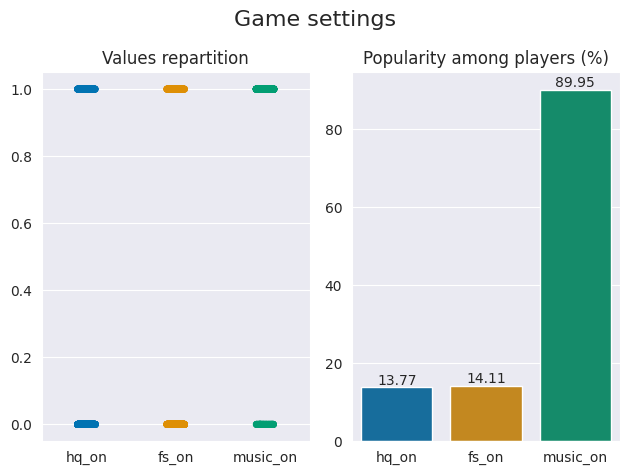

In [31]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("Game settings", fontsize=16)

# Values repartition
sns.stripplot(game_settings, ax=axes[0]).set(title="Values repartition")

# Popularity per setting among players
sns.barplot(x=on_rate.index, y=on_rate.values * 100, ax=axes[1]).set(
    title="Popularity among players (%)"
)
axes[1].bar_label(axes[1].containers[0], fmt="%.2f")

fig.tight_layout()
plt.show()

Metrics correlations

In [47]:
filter_cols = [
    "session_id",
    "median_time",
    "hover_percent",
    "hq_on",
    "fs_on",
    "music_on",
]

We can see that players who produced less events during their game session tend to get a better score.

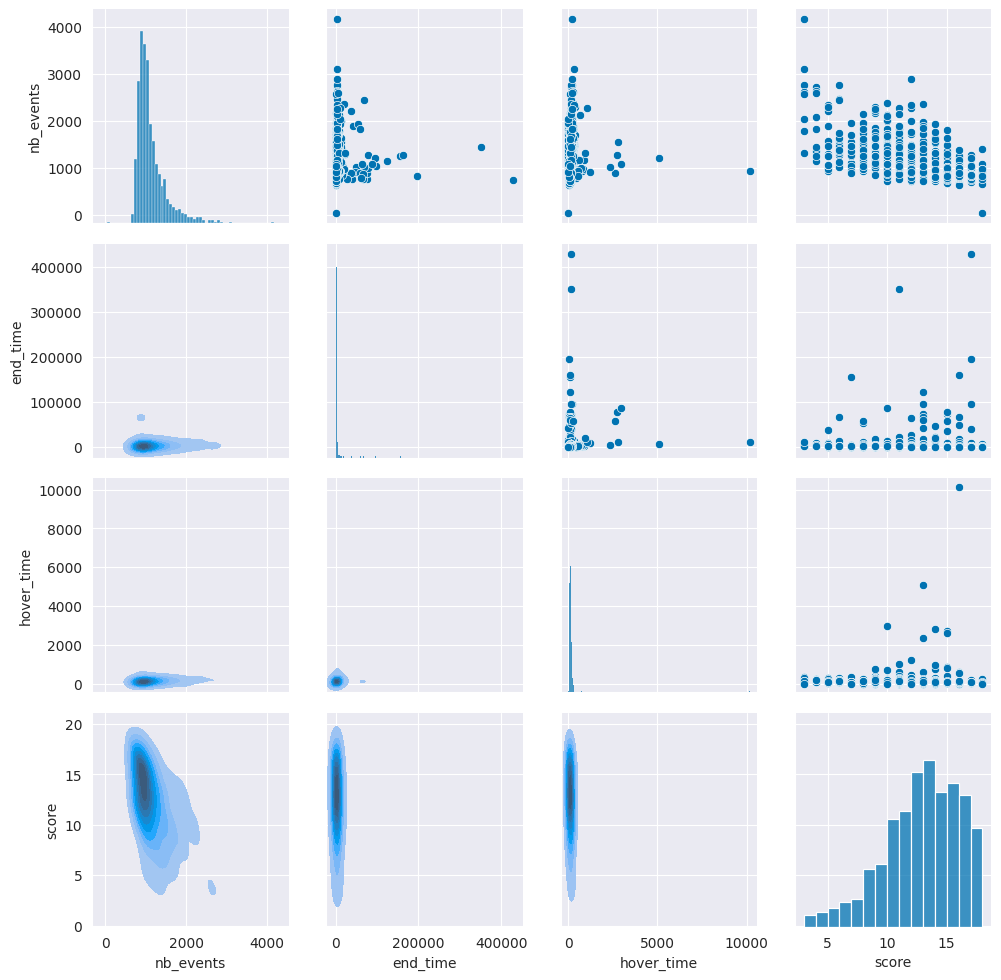

In [88]:
variables = ["nb_events", "end_time", "hover_time", "score"]

g = sns.PairGrid(players_profile, vars=variables)
g.map_diag(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_upper(sns.scatterplot)

plt.show()

Do players who finished the game fast have a better score ?

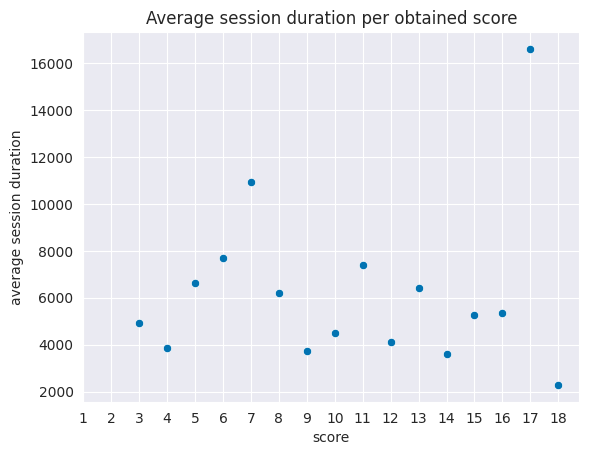

In [91]:
sns.scatterplot(
    players_profile.groupby("score")["end_time"].mean().reset_index(),
    x="score",
    y="end_time",
).set(title="Average session duration per obtained score")

plt.xticks(np.arange(1, 19))
plt.xlabel("score")
plt.ylabel("average session duration")
plt.show()